In [2]:
import pandas as pd, numpy as np
from sklearn.metrics import f1_score, accuracy_score
from itertools import product
from scipy import stats
from scipy.stats import ttest_ind  
from statsmodels.stats.multitest import multipletests  
from glob import glob
import matplotlib.pyplot as plt  
import seaborn as sns

In [3]:
# Increase font sizes  
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Analysis of Semeval Results

In [13]:
# List of CSV files  
csv_files = glob("bias results/semeval_*.csv")  

In [14]:
# Dataframe to hold results  
results = []

for file in csv_files:  
    # Read CSV file  
    df = pd.read_csv(file)  
      
    # Define the events that lead to left or right bias  
    left_events = ['Climate Change is a Real Concern', 'Feminist Movement', 'Hillary Clinton', 'Legalization of Abortion']  
    right_events = ['Atheism', 'Climate Change is a Real Concern', 'Feminist Movement', 'Hillary Clinton', 'Legalization of Abortion']  
  
    # Create 'bias' column based on 'event' and 'stance' columns  
    df['bias'] = df.apply(lambda row: 'left' if row['event'] in left_events and row['stance'] == 'agree' else   
                          ('right' if row['event'] in right_events and row['stance'] == 'disagree' else 'none'), axis=1)
      
    # Get model name from file name  
    model_name = file.split("_")[1].split(".")[0]  
      
    # Compute F1 score for 'left' and 'right' biases  
    for bias in ['left', 'right']:  
        for col in ["task_preds", "context_preds", "cot_preds", "bias_cot_preds"]:  
            sub_df = df[df['bias'] == bias]  
            acc = accuracy_score(sub_df['stance'], sub_df[col])  
  
            # Append result to results list  
            result = {"model": model_name, "column": col, "accuracy_score": acc, "bias": bias}  
            results.append(result)

In [15]:
results_df = pd.DataFrame(results)
semeval_results_df = results_df.pivot(index=['model', 'bias'], columns='column', values='accuracy_score')

index_mapping = {
    'Llama-2-13b-chat-hf': 'Llama-2 13B Chat',
    'Llama-2-7b-chat-hf': 'Llama-2 7B Chat',
    'Mistral-7B-Instruct-v0': 'Mistral-v0.1 7B Instruct',
    'falcon-40b-instruct': 'Falcon 40B Instruct',
    'falcon-7b-instruct': 'Falcon 7B Instruct',
    'flan-alpaca-gpt4-xl': 'T5-XL Flan-Alpaca',
    'flan-ul2': 'UL2 20B Flan',
    'gpt-3': 'GPT-3.5'
}

# Rename the index using the mapping
semeval_results_df = semeval_results_df.rename(index=index_mapping)

column_mapping = {
    'task_preds': 'Task-Only',
    'context_preds': 'Context',
    'cot_preds': 'CoT',
    'bias_cot_preds': 'Bias CoT'
}

# Rename the columns using the mapping
semeval_results_df = semeval_results_df.rename(columns=column_mapping)

In [16]:
# Create counts_df dataframe  
counts_df = df['bias'].value_counts().reset_index()  
counts_df.columns = ['bias', 'count']  

In [17]:
counts_df

,bias,count
0,right,1342
1,none,833
2,left,639


In [18]:
semeval_results_df

column                          Bias CoT   Context       CoT  Task-Only
model                    bias                                          
Llama-2 13B Chat         left   0.668232  0.356808  0.638498   0.245696
                         right  0.728763  0.776453  0.749627   0.619225
Llama-2 7B Chat          left   0.386541  0.525822  0.416275   0.787167
                         right  0.742176  0.692250  0.730253   0.360656
Mistral-v0.1 7B Instruct left   0.275430  0.424100  0.306729   0.381847
                         right  0.743666  0.819672  0.727273   0.745902
Falcon 40B Instruct      left   0.428795  0.142410  0.488263   0.097027
                         right  0.777198  0.935917  0.743666   0.786885
Falcon 7B Instruct       left   0.053208  0.431925  0.089202   0.164319
                         right  0.489568  0.486587  0.447094   0.530551
T5-XL Flan-Alpaca        left   0.400626  0.497653  0.399061   0.461659
                         right  0.744411  0.824143  0.733979   0.584948
UL2 20B Flan             left   0.748044  0.773083  0.801252   0.455399
                         right  0.819672  0.829359  0.827124   0.652757
GPT-3.5                  left   0.665102  0.751174  0.610329   0.197183
                         right  0.764531  0.672131  0.766766   0.484352

In [19]:
semeval_results_df.to_csv("bias results/Analysis Results/bias_results_semeval.csv")

In [20]:
# Separate the dataframe into two: one for 'right' and one for 'left'  
right_df = semeval_results_df.xs('right', level='bias')  
left_df = semeval_results_df.xs('left', level='bias')  
  
# Calculate the difference between 'right' and 'left' accuracy scores for each model and prompt 
diff_df_semeval = right_df - left_df
  
# Flatten the difference dataframe and remove NaN values  
diff_values = diff_df_semeval.values.flatten()
diff_values = diff_values[~np.isnan(diff_values)]
  
# Perform a One-Sample T-test  
t_stat, p_val = stats.ttest_1samp(np.abs(diff_values), 0)  
  
print(f"t-statistic: {t_stat}, p-value: {p_val} for whether there is a difference in accuracy of prediction between the right leaning stances and the right leaning stances")  

t-statistic: 8.994147892129572, p-value: 3.7830999330032917e-10 for whether there is a difference in accuracy of prediction between the right leaning stances and the right leaning stances


In [81]:
for column in diff_df_semeval.columns:
    # Perform one-sample t-test
    t_statistic, p_value = stats.ttest_1samp(diff_df_semeval[column], 0)
    
    # Print results
    print(f"Column: {column}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    print(f"is significant: {p_value < 0.01}")
    print("")

Column: Bias CoT
T-statistic: 4.589471795406212
P-value: 0.0025153476988668093
is significant: True

Column: Context
T-statistic: 2.7160367613248417
P-value: 0.0299365889451153
is significant: False

Column: CoT
T-statistic: 5.121799100566667
P-value: 0.0013660173937536124
is significant: True

Column: Task-Only
T-statistic: 2.1877912855932617
P-value: 0.06489001090037368
is significant: False



# Analysis of Election Results

In [60]:
# List of CSV files  
csv_files = glob("bias results/election_*.csv")

In [61]:
# Dataframe to hold results  
results = []

for file in csv_files:  
    # Read CSV file
    df = pd.read_csv(file)  

    # Create 'bias' column based on 'stance' and 'event' values  
    conditions = [(df['stance'] == 'agree') & (df['event'] == 'Donald Trump'),  
                  (df['stance'] == 'disagree') & (df['event'] == 'Hillary Clinton'),  
                  (df['stance'] == 'agree') & (df['event'] == 'Hillary Clinton'),  
                  (df['stance'] == 'disagree') & (df['event'] == 'Donald Trump')]  
    choices = ['right', 'right', 'left', 'left']  
    df['bias'] = np.select(conditions, choices, default='none')  

    # Get model name from file name  
    model_name = file.split("_")[1].split(".")[0]  
    # Compute F1 score for 'left' and 'right' biases  
    for bias in ['left', 'right']:  
        for col in ["task_preds", "context_preds", "cot_preds", "bias_cot_preds"]:  
            sub_df = df[df['bias'] == bias]  
            acc = accuracy_score(sub_df['stance'], sub_df[col])  

            # Append result to results list  
            result = {"model": model_name, "column": col, "accuracy_score": acc, "bias": bias}  
            results.append(result)

In [62]:
results_df = pd.DataFrame(results)
election_results_df = results_df.pivot(index=['model', 'bias'], columns='column', values='accuracy_score')

index_mapping = {
    'Llama-2-13b-chat-hf': 'Llama-2 13B Chat',
    'Llama-2-7b-chat-hf': 'Llama-2 7B Chat',
    'Mistral-7B-Instruct-v0': 'Mistral-v0.1 7B Instruct',
    'falcon-40b-instruct': 'Falcon 40B Instruct',
    'falcon-7b-instruct': 'Falcon 7B Instruct',
    'flan-alpaca-gpt4-xl': 'T5-XL Flan-Alpaca',
    'flan-ul2': 'UL2 20B Flan',
    'gpt-3': 'GPT-3.5'
}

# Rename the index using the mapping
election_results_df = election_results_df.rename(index=index_mapping)

column_mapping = {
    'task_preds': 'Task-Only',
    'context_preds': 'Context',
    'cot_preds': 'CoT',
    'bias_cot_preds': 'Bias CoT'
}

# Rename the columns using the mapping
election_results_df = election_results_df.rename(columns=column_mapping)

In [63]:
# Create counts_df dataframe  
counts_df = df['bias'].value_counts().reset_index()  
counts_df.columns = ['bias', 'count']  

In [64]:
counts_df

,bias,count
0,right,1111
1,left,690
2,none,577


In [65]:
election_results_df

column                          Bias CoT   Context       CoT  Task-Only
model                    bias                                          
Llama-2 13B Chat         left   0.717391  0.726087  0.721739   0.436232
                         right  0.595860  0.445545  0.590459   0.317732
Llama-2 7B Chat          left   0.665217  0.765217  0.646377   0.668116
                         right  0.432043  0.507651  0.435644   0.501350
Mistral-v0.1 7B Instruct left   0.642029  0.749275  0.639130   0.715942
                         right  0.428443  0.464446  0.414941   0.417642
Falcon 40B Instruct      left   0.717391  0.727536  0.708696   0.688406
                         right  0.487849  0.372637  0.475248   0.358236
Falcon 7B Instruct       left   0.469565  0.721739  0.428986   0.547826
                         right  0.208821  0.360936  0.177318   0.269127
T5-XL Flan-Alpaca        left   0.681159  0.752174  0.678261   0.643478
                         right  0.344734  0.421242  0.342934   0.378938
UL2 20B Flan             left   0.797101  0.782609  0.802899   0.682609
                         right  0.628263  0.504950  0.610261   0.417642
GPT-3.5                  left   0.224638  0.240580  0.740580   0.210145
                         right  0.603960  0.609361  0.560756   0.538254

In [66]:
election_results_df.to_csv("bias results/Analysis Results/bias_results_election.csv")

In [67]:
# Separate the dataframe into two: one for 'right' and one for 'left'  
right_df = election_results_df.xs('right', level='bias')  
left_df = election_results_df.xs('left', level='bias')  
  
# Calculate the difference between 'right' and 'left' F1 scores for each model and column  
diff_df_election = right_df - left_df
  
# Flatten the difference dataframe and remove NaN values  
diff_values = diff_df_election.values.flatten()
diff_values = diff_values[~np.isnan(diff_values)]
  
# Perform a One-Sample T-test  
t_stat, p_val = stats.ttest_1samp(np.abs(diff_values), 0)  
  
print(f"t-statistic: {t_stat}, p-value: {p_val} for whether there is a difference in accuracy of prediction between the right leaning stances and the right leaning stances")  

t-statistic: 19.944120538175028, p-value: 3.0527701402550907e-19 for whether there is a difference in accuracy of prediction between the right leaning stances and the right leaning stances


In [79]:
for column in diff_df_semeval.columns:
    # Perform one-sample t-test
    t_statistic, p_value = stats.ttest_1samp(diff_df_election[column], 0)
    
    # Print results
    print(f"Column: {column}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    print(f"is significant: {p_value < 0.01}")
    print("")

Column: Bias CoT
T-statistic: -1.8847076161565446
P-value: 0.10146155005557263
is significant: False

Column: Context
T-statistic: -2.5995005285746315
P-value: 0.03545093161388908
is significant: False

Column: CoT
T-statistic: -10.444404461500593
P-value: 1.6051007936393377e-05
is significant: True

Column: Task-Only
T-statistic: -2.2958153776656953
P-value: 0.05533125501755931
is significant: False



# Analysis of BASIL Results

In [70]:
# List of CSV files  
csv_files = glob("bias results/basil_*.csv")  

In [71]:
# Dataframe to hold results  
results = []

for file in csv_files:  
    # Read CSV file  
    df = pd.read_csv(file)  
      
    # Create 'bias' column  
    df['bias'] = df['relative_stance'].map({'liberal': 'left', 'left': 'left', 'conservative': 'right', 'right': 'right'}).fillna('none')
      
    # Get model name from file name  
    model_name = file.split("_")[1].split(".")[0]  
      
    # Compute F1 score for 'left' and 'right' biases  
    for bias in ['left', 'right']:  
        for col in ["task_preds", "context_preds", "cot_preds", "bias_cot_preds"]:  
            sub_df = df[df['bias'] == bias]  
            acc = accuracy_score(sub_df['stance'], sub_df[col])  
  
            # Append result to results list  
            result = {"model": model_name, "column": col, "accuracy_score": acc, "bias": bias}  
            results.append(result)

In [72]:
results_df = pd.DataFrame(results)
basil_results_df = results_df.pivot(index=['model', 'bias'], columns='column', values='accuracy_score')

index_mapping = {
    'Llama-2-13b-chat-hf': 'Llama-2 13B Chat',
    'Llama-2-7b-chat-hf': 'Llama-2 7B Chat',
    'Mistral-7B-Instruct-v0': 'Mistral-v0.1 7B Instruct',
    'falcon-40b-instruct': 'Falcon 40B Instruct',
    'falcon-7b-instruct': 'Falcon 7B Instruct',
    'flan-alpaca-gpt4-xl': 'T5-XL Flan-Alpaca',
    'flan-ul2': 'UL2 20B Flan',
    'gpt-3': 'GPT-3.5'
}

# Rename the index using the mapping
basil_results_df = basil_results_df.rename(index=index_mapping)

column_mapping = {
    'task_preds': 'Task-Only',
    'context_preds': 'Context',
    'cot_preds': 'CoT',
    'bias_cot_preds': 'Bias CoT'
}

# Rename the columns using the mapping
basil_results_df = basil_results_df.rename(columns=column_mapping)

In [73]:
# Create counts_df dataframe  
counts_df = df['bias'].value_counts().reset_index()  
counts_df.columns = ['bias', 'count']  

In [74]:
counts_df

,bias,count
0,none,289
1,left,170
2,right,153


In [75]:
basil_results_df

column                          Bias CoT   Context       CoT  Task-Only
model                    bias                                          
Llama-2 13B Chat         left   0.594118  0.523529  0.588235   0.558824
                         right  0.424837  0.405229  0.457516   0.535948
Llama-2 7B Chat          left   0.582353  0.482353  0.441176   0.600000
                         right  0.477124  0.379085  0.431373   0.509804
Mistral-v0.1 7B Instruct left   0.523529  0.488235  0.517647   0.382353
                         right  0.496732  0.398693  0.516340   0.320261
Falcon 40B Instruct      left   0.558824  0.564706  0.576471   0.558824
                         right  0.607843  0.457516  0.627451   0.418301
Falcon 7B Instruct       left   0.541176  0.458824  0.535294   0.394118
                         right  0.444444  0.444444  0.503268   0.287582
T5-XL Flan-Alpaca        left   0.594118  0.423529  0.576471   0.376471
                         right  0.483660  0.333333  0.509804   0.307190
UL2 20B Flan             left   0.305882  0.370588  0.194118   0.276471
                         right  0.241830  0.281046  0.183007   0.189542
GPT-3.5                  left   0.547059  0.482353  0.588235   0.494118
                         right  0.490196  0.450980  0.477124   0.398693

In [76]:
basil_results_df.to_csv("bias results/Analysis Results/bias_results_basil.csv")

In [82]:
# Separate the dataframe into two: one for 'right' and one for 'left'  
right_df = basil_results_df.xs('right', level='bias')  
left_df = basil_results_df.xs('left', level='bias')  
  
# Calculate the difference between 'right' and 'left' F1 scores for each model and column  
diff_df_basil = right_df - left_df
  
# Flatten the difference dataframe and remove NaN values  
diff_values = diff_df_basil.values.flatten()
diff_values = diff_values[~np.isnan(diff_values)]
  
# Perform a One-Sample T-test  
t_stat, p_val = stats.ttest_1samp(np.abs(diff_values), 0)  
  
print(f"t-statistic: {t_stat}, p-value: {p_val} for whether there is a difference in accuracy of prediction between the right leaning stances and the left leaning stances")  

t-statistic: 10.152641415206013, p-value: 2.2291312065940444e-11 for whether there is a difference in accuracy of prediction between the right leaning stances and the left leaning stances


In [83]:
for column in diff_df_semeval.columns:
    # Perform one-sample t-test
    t_statistic, p_value = stats.ttest_1samp(diff_df_basil[column], 0)
    
    # Print results
    print(f"Column: {column}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    print(f"is significant: {p_value < 0.01}")
    print("")

Column: Bias CoT
T-statistic: -3.1535963499784274
P-value: 0.016071210578428672
is significant: False

Column: Context
T-statistic: -6.113701092264191
P-value: 0.0004845008961918005
is significant: True

Column: CoT
T-statistic: -1.8236132468370794
P-value: 0.11097939881588668
is significant: False

Column: Task-Only
T-statistic: -6.913593293270591
P-value: 0.0002285226713466669
is significant: True



## Look at the differences between the data sets

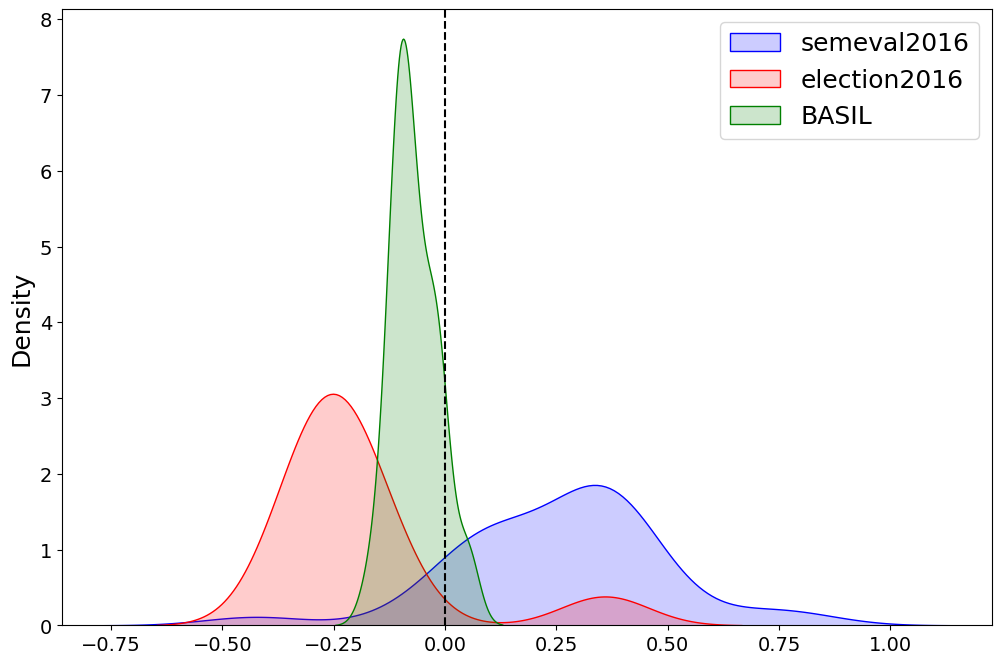

In [53]:
# Flatten the difference dataframes
diff_values1 = diff_df_semeval.values.flatten()
diff_values2 = diff_df_election.values.flatten()
diff_values3 = diff_df_basil.values.flatten()

# Specify figure size (width, height)
plt.figure(figsize=(12, 8))
  
# Create density plots
sns.kdeplot(diff_values1, color='blue', label='semeval2016', fill=True, alpha=0.2)
sns.kdeplot(diff_values2, color='red', label='election2016', fill=True, alpha=0.2)
sns.kdeplot(diff_values3, color='green', label='BASIL', fill=True, alpha=0.2)

plt.axvline(0, color='black', linestyle='--')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [38]:
# Create a list of the flattened arrays  
diff_values = [diff_values1, diff_values2, diff_values3]  
  
# Create a list to store p-values  
p_values = []  
  
# Loop through each pair of flattened arrays  
for i in range(len(diff_values)):  
    for j in range(i+1, len(diff_values)):  
        # Perform independent t-test  
        t_stat, p_val = ttest_ind(diff_values[i], diff_values[j])  
        p_values.append(p_val)  

# Apply Bonferroni correction  
_, p_values_corrected, _, _ = multipletests(p_values, method='bonferroni')  
  
# Print the corrected p-values  
for i in range(len(p_values_corrected)):  
    print(f'Pair {i+1}: Corrected P-value: {p_values_corrected[i]}')  

# Check if any corrected p-value is less than the significance level (e.g., 0.05)  
significant_diff = any(p < 0.05 for p in p_values_corrected)  
  
print(f'Is there at least one pair of arrays significantly different from the others? {significant_diff}. If true that means that performance across models and prompt schemes on at least one dataset if different than on the other datasets')  

Pair 1: Corrected P-value: 1.1539506233342399e-11
Pair 2: Corrected P-value: 1.2719777903087568e-10
Pair 3: Corrected P-value: 0.002733971686851736
Is there at least one pair of arrays significantly different from the others? True. If true that means that performance across models and prompt schemes on at least one dataset if different than on the other datasets


# Do Statistical Analysis across the models

In [48]:
# looking across all of the datasets and prompting schemes, do the statistical analysis for the models
  
# First, we'll concatenate all three dataframes  
all_results_df = pd.concat([basil_results_df, election_results_df, semeval_results_df], axis=1)  
  
right_df = all_results_df.xs('right', level='bias')  
left_df = all_results_df.xs('left', level='bias')  
  
# Calculate the difference between 'right' and 'left' F1 scores for each model and column  
diff_all_results_df = right_df - left_df

new_index_mapping = {
    'Llama-2-13b-chat-hf': 'Llama-2 13B Chat',
    'Llama-2-7b-chat-hf': 'Llama-2 7B Chat',
    'Mistral-7B-Instruct-v0': 'Mistral-v0.1 7B Instruct',
    'falcon-40b-instruct': 'Falcon 40B Instruct',
    'falcon-7b-instruct': 'Falcon 7B Instruct',
    'flan-alpaca-gpt4-xl': 'T5-XL Flan-Alpaca',
    'flan-ul2': 'UL2 20B Flan',
    'gpt-3': 'GPT-3.5'
}

# Rename the index using the mapping
diff_all_results_df = diff_all_results_df.rename(index=new_index_mapping)
  
# Calculate the statistical significance for each row having a zero-mean or not  
for idx, row in diff_all_results_df.iterrows():  
    t_stat, p_val = stats.ttest_1samp(np.abs(row.dropna()), 0)  
    print(f'For model {idx}: T-statistic: {t_stat}, P-value: {p_val}') 

For model Llama-2 13B Chat: T-statistic: 4.8688940536845795, P-value: 0.0004955823958053356
For model Llama-2 7B Chat: T-statistic: 5.807414341927942, P-value: 0.00011800257598684557
For model Mistral-v0.1 7B Instruct: T-statistic: 5.0892869871339155, P-value: 0.0003498588418105953
For model Falcon 40B Instruct: T-statistic: 4.425782324733842, P-value: 0.001018709388853625
For model Falcon 7B Instruct: T-statistic: 5.050022652477617, P-value: 0.0003720623739617569
For model T5-XL Flan-Alpaca: T-statistic: 6.445332732506991, P-value: 4.7726770820166075e-05
For model UL2 20B Flan: T-statistic: 4.771731440325188, P-value: 0.0005790645985105341
For model GPT-3.5: T-statistic: 4.970695950959704, P-value: 0.00042159358567634683


In [49]:
# test to see if any models are statistically different than any other models

# Create a list to store p-values  
p_values = []  
  
# Loop through each pair of rows  
for i in range(len(diff_all_results_df)):  
    for j in range(i+1, len(diff_all_results_df)):  
        # Perform independent t-test  
        t_stat, p_val = ttest_ind(diff_all_results_df.iloc[i].dropna(), diff_all_results_df.iloc[j].dropna())  
        p_values.append(p_val)
        
# Apply Bonferroni correction  
_, p_values_corrected, _, _ = multipletests(p_values, method='bonferroni')  
  
# Check if any corrected p-value is less than the significance level (e.g., 0.05)  
significant_diff = any(p < 0.05 for p in p_values_corrected)  
  
print(f'Is there at least one model significantly different from the others in terms of its differences in performance between biases? {significant_diff}. If true than at least one model has different performance across datasets and prompting schemes, than all of the other models.')  

Is there at least one model significantly different from the others in terms of its differences in performance between biases? False. If true than at least one model has different performance across datasets and prompting schemes, than all of the other models.


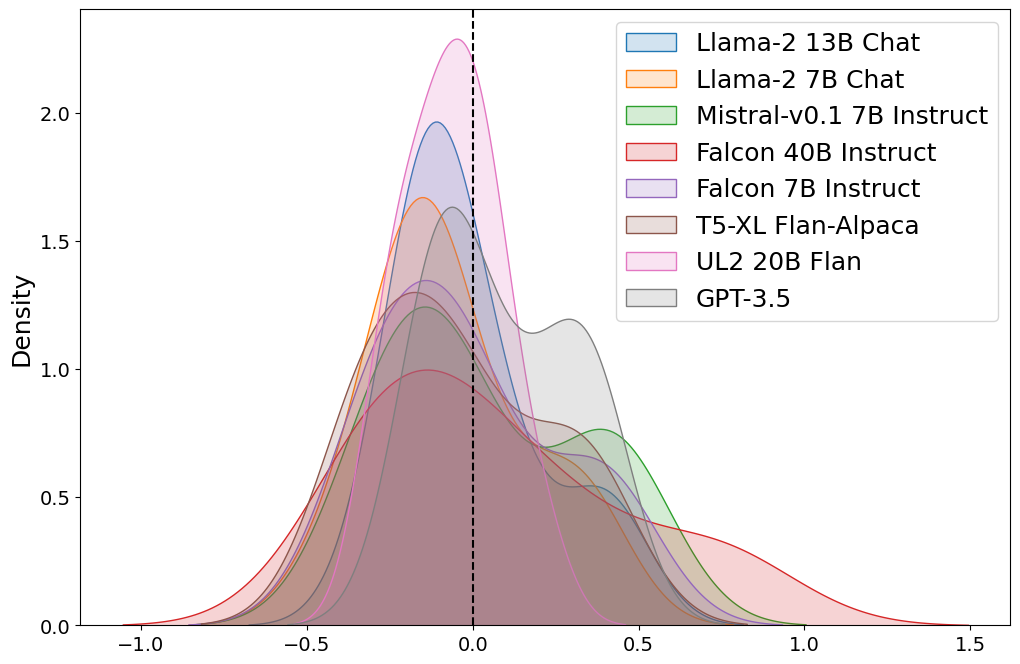

In [50]:
# Specify figure size (width, height)  
plt.figure(figsize=(12, 8))  
  
# Iterate over each row in the dataframe  
for idx, row in diff_all_results_df.iterrows():  
    # Flatten the row values  
    diff_values = row.values.flatten()  
    # Create a density plot for this model's values  
    sns.kdeplot(diff_values, label=idx, fill=True, alpha=0.2)  

plt.axvline(0, color='black', linestyle='--')  
  
# Show legend  
plt.legend()  
  
# Display the plot  
plt.show()

In [52]:
diff_all_results_df.mean(axis=1)

model
Llama-2 13B Chat           -0.010683
Llama-2 7B Chat            -0.063934
Mistral-v0.1 7B Instruct    0.037314
Falcon 40B Instruct         0.065950
Falcon 7B Instruct         -0.015537
T5-XL Flan-Alpaca          -0.039612
UL2 20B Flan               -0.067050
GPT-3.5                     0.088801
dtype: float64

# Do statistical analysis across the prompting schemes

In [42]:
# looking across all of the datasets and models, do the statistical analysis for the prompting schemes
  
# First, we'll concatenate all three dataframes  
all_results_df = pd.concat([basil_results_df, election_results_df, semeval_results_df], axis=0)  
  
right_df = all_results_df.xs('right', level='bias')  
left_df = all_results_df.xs('left', level='bias')  
  
# Calculate the difference between 'right' and 'left' F1 scores for each model and column  
diff_all_results_df = right_df - left_df

new_column_mapping = {
    'bias_cot_preds': 'Bias CoT',
    'context_preds': 'Context',
    'cot_preds': 'CoT',
    'task_preds': 'Task-Only'
}

# Rename the columns using the mapping
diff_all_results_df = diff_all_results_df.rename(columns=new_column_mapping)

# Calculate the statistical significance for each column having a zero-mean or not  
for column in diff_all_results_df.columns:  
    t_stat, p_val = stats.ttest_1samp(np.abs(diff_all_results_df[column].dropna()), 0)  
    print(f'For column {column}: T-statistic: {t_stat}, P-value: {p_val}')

For column Bias CoT: T-statistic: 7.217134133556289, P-value: 2.3947794028315874e-07
For column Context: T-statistic: 6.215908766815408, P-value: 2.4243547152724737e-06
For column CoT: T-statistic: 6.860442969430646, P-value: 5.384895434737311e-07
For column Task-Only: T-statistic: 7.35040657782965, P-value: 1.776741950444987e-07


In [43]:
# test to see if any prompting schemes are statistically significant from any other prompting schemes

# Create a list to store p-values  
p_values = []  
  
# Loop through each pair of columns  
for i in range(len(diff_all_results_df.columns)):  
    for j in range(i+1, len(diff_all_results_df.columns)):  
        # Perform independent t-test  
        t_stat, p_val = ttest_ind(diff_all_results_df.iloc[:, i].dropna(), diff_all_results_df.iloc[:, j].dropna())  
        p_values.append(p_val)  
        
        
# Apply Bonferroni correction  
_, p_values_corrected, _, _ = multipletests(p_values, method='bonferroni')  
  
# Check if any corrected p-value is less than the significance level (e.g., 0.05)  
significant_diff = any(p < 0.05 for p in p_values_corrected)  
  
print(f'Is there at least one prompting scheme significantly different from the others in terms of its performance for different biases? {significant_diff}. If true than there is at least one prompting scheme that produces significantly different results across all models and datasets than the other prompting schemes.')  

Is there at least one prompting scheme significantly different from the others in terms of its performance for different biases? False. If true than there is at least one prompting scheme that produces significantly different results across all models and datasets than the other prompting schemes.


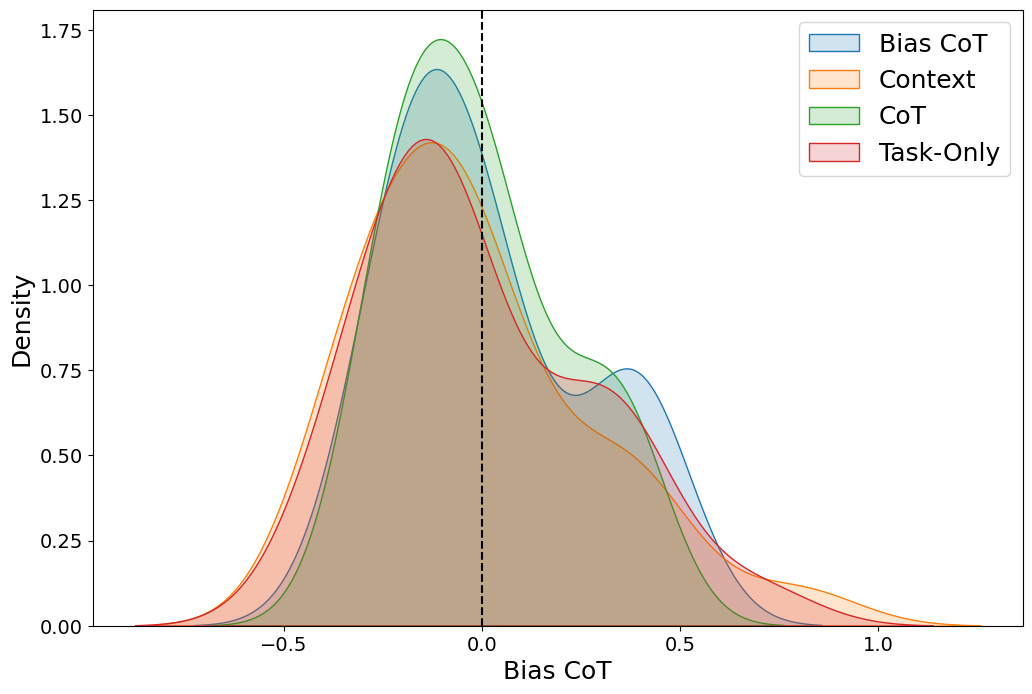

In [44]:
# Specify figure size (width, height)  
plt.figure(figsize=(12, 8))  
  
# Iterate over each column in the dataframe  
for column in diff_all_results_df.columns:  
    # Create a density plot for this column's values  
    sns.kdeplot(diff_all_results_df[column].dropna(), label=column, fill=True, alpha=0.2)  
    
    
plt.axvline(0, color='black', linestyle='--')  
  
# Show legend  
plt.legend()  
  
# Display the plot  
plt.show()  

In [45]:
diff_all_results_df.mean(axis=0)

column
Bias CoT     0.017462
Context     -0.012029
CoT         -0.003946
Task-Only   -0.003863
dtype: float64

# Get Performance across all Data

In [104]:
models = ['gpt-3.5-turbo', 'falcon-40b-instruct', 'falcon-7b-instruct', 'flan-alpaca-gpt4-xl', 'flan-ul2', 'Llama-2-13b-chat-hf', 'Llama-2-7b-chat-hf', 'Mistral-7B-Instruct-v0.1']
prompts = ['task_preds', 'context_preds', 'cot_preds', 'bias_cot_preds']
datasets = ['semeval','election','basil']

# Initialize an empty dataframe to store F1-scores
f1_scores_df = pd.DataFrame(index=pd.MultiIndex.from_product([datasets, models], names=['dataset', 'model']), columns=prompts)

In [106]:
# Loop through each dataset and model
for dataset, model in product(datasets, models):
    # Read the CSV file
    file_path = f"bias results/{dataset}_{model}.csv"
    df = pd.read_csv(file_path)

    # Loop through each column and calculate correlation
    for column in prompts:
        try:
            f1 = f1_score(df['stance'], df[column], average='macro')
        except KeyError:
            f1 = np.nan
        
        f1_scores_df.loc[(dataset, model), column] = f1


In [107]:
f1_scores_df

task_preds context_preds cot_preds  \
dataset  model                                                         
semeval  gpt-3.5-turbo              0.411232      0.607517  0.627932   
         falcon-40b-instruct        0.383336      0.389725  0.482277   
         falcon-7b-instruct         0.371169      0.421436  0.355213   
         flan-alpaca-gpt4-xl        0.405252       0.58426  0.563007   
         flan-ul2                   0.475357      0.695348  0.699025   
         Llama-2-13b-chat-hf        0.390566      0.527913  0.505715   
         Llama-2-7b-chat-hf         0.293141      0.432168  0.469991   
         Mistral-7B-Instruct-v0.1    0.33129       0.51366  0.511902   
election gpt-3.5-turbo              0.408085      0.545778  0.386617   
         falcon-40b-instruct        0.318987      0.257171  0.441184   
         falcon-7b-instruct         0.342223      0.290636  0.303773   
         flan-alpaca-gpt4-xl        0.424318      0.416799  0.399587   
         flan-ul2                   0.416733      0.533108  0.556857   
         Llama-2-13b-chat-hf        0.365513       0.40191  0.464418   
         Llama-2-7b-chat-hf         0.333407      0.350914  0.414451   
         Mistral-7B-Instruct-v0.1   0.294736      0.362732  0.416159   
basil    gpt-3.5-turbo              0.308314      0.312876  0.383147   
         falcon-40b-instruct        0.319176      0.351482  0.383738   
         falcon-7b-instruct         0.264897       0.33486  0.313459   
         flan-alpaca-gpt4-xl        0.263476      0.283125  0.361258   
         flan-ul2                   0.184881       0.23055  0.145119   
         Llama-2-13b-chat-hf         0.37345      0.349487  0.363108   
         Llama-2-7b-chat-hf          0.29687      0.327826  0.352809   
         Mistral-7B-Instruct-v0.1   0.252106      0.336964  0.329505   

                                  bias_cot_preds  
dataset  model                                    
semeval  gpt-3.5-turbo                  0.636742  
         falcon-40b-instruct            0.492836  
         falcon-7b-instruct             0.346071  
         flan-alpaca-gpt4-xl            0.553636  
         flan-ul2                       0.706162  
         Llama-2-13b-chat-hf            0.499547  
         Llama-2-7b-chat-hf             0.454259  
         Mistral-7B-Instruct-v0.1        0.50431  
election gpt-3.5-turbo                  0.336816  
         falcon-40b-instruct            0.442383  
         falcon-7b-instruct             0.309574  
         flan-alpaca-gpt4-xl            0.401174  
         flan-ul2                       0.561042  
         Llama-2-13b-chat-hf            0.457447  
         Llama-2-7b-chat-hf             0.408509  
         Mistral-7B-Instruct-v0.1       0.426005  
basil    gpt-3.5-turbo                  0.373418  
         falcon-40b-instruct            0.382737  
         falcon-7b-instruct             0.315852  
         flan-alpaca-gpt4-xl            0.362227  
         flan-ul2                       0.196935  
         Llama-2-13b-chat-hf            0.361089  
         Llama-2-7b-chat-hf              0.36402  
         Mistral-7B-Instruct-v0.1       0.323848

In [109]:
f1_scores_df.to_csv("bias results/Analysis Results/F1_scores.csv")

# Look at Differences in Performance in Overlap Classes
- Hillary Clinton
- Donald Trump

In [37]:
# List of CSV files  
csv_files = glob("bias results/*.csv")  

In [38]:
# Dataframe to hold results  
results = []

for file in csv_files:  
    # Read CSV file  
    df = pd.read_csv(file)
      
    # Get model name from file name  
    model_name = file.split("_")[1].split(".")[0]
    
    # Get dataset name from file split
    dataset_name = file.split("_")[0].split("/")[1]
        
    # Compute F1 scores
    for target in ['Hillary Clinton']:  
        for col in ["task_preds", "context_preds", "cot_preds", "bias_cot_preds"]:  
            sub_df = df[df['event'] == target]  
            acc = f1_score(sub_df['stance'], sub_df[col], average='macro')  
  
            # Append result to results list  
            result = {"model": model_name, "dataset_name": dataset_name, "prompt": col, "accuracy_score": acc, "num_samples":len(sub_df)}  
            results.append(result)

In [39]:
results_df = pd.DataFrame(results)
clinton_results_df = results_df.pivot(index=['model', "prompt"], columns='dataset_name', values='accuracy_score')

In [40]:
clinton_results_df

dataset_name                              basil  election   semeval
model                  prompt                                      
Llama-2-13b-chat-hf    bias_cot_preds  0.317460  0.458395  0.491623
                       context_preds   0.340054  0.450164  0.594364
                       cot_preds       0.362500  0.467461  0.501313
                       task_preds      0.317460  0.367834  0.461516
Llama-2-7b-chat-hf     bias_cot_preds  0.284127  0.455642  0.497381
                       context_preds   0.223325  0.412679  0.474636
                       cot_preds       0.575758  0.456878  0.546479
                       task_preds      0.374074  0.334080  0.289227
Mistral-7B-Instruct-v0 bias_cot_preds  0.301347  0.446177  0.594253
                       context_preds   0.348387  0.414627  0.586183
                       cot_preds       0.301347  0.431331  0.590548
                       task_preds      0.405263  0.332603  0.437351
falcon-40b-instruct    bias_cot_preds  0.356838  0.490514  0.529765
                       context_preds   0.380471  0.338043  0.489991
                       cot_preds       0.285714  0.476522  0.518298
                       task_preds      0.284127  0.380100  0.468242
falcon-7b-instruct     bias_cot_preds  0.245614  0.344530  0.400292
                       context_preds   0.324786  0.369899  0.514024
                       cot_preds       0.266667  0.335116  0.410898
                       task_preds      0.187500  0.382468  0.426569
flan-alpaca-gpt4-xl    bias_cot_preds  0.337232  0.498407  0.595590
                       context_preds   0.301555  0.514699  0.614816
                       cot_preds       0.337232  0.498407  0.611561
                       task_preds      0.300000  0.466657  0.495735
flan-ul2               bias_cot_preds  0.320635  0.554699  0.654034
                       context_preds   0.278889  0.602759  0.677404
                       cot_preds       0.160428  0.562452  0.648455
                       task_preds      0.209506  0.437516  0.563549
gpt-3                  bias_cot_preds  0.421569  0.261281  0.683848
                       context_preds   0.325000  0.570215  0.639433
                       cot_preds       0.357911  0.307764  0.699290
                       task_preds      0.348387  0.448230  0.521563

In [41]:
diff_values = pd.concat([clinton_results_df['basil']-clinton_results_df['election'], 
                         clinton_results_df['basil']-clinton_results_df['semeval'],
                         clinton_results_df['election']-clinton_results_df['semeval']])
diff_values = diff_values[~np.isnan(diff_values)]
  
# Perform a One-Sample T-test  
t_stat, p_val = stats.ttest_1samp(np.abs(diff_values), 0)  
  
print(f"t-statistic: {t_stat}, p-value: {p_val}")  

t-statistic: 15.198419372248868, p-value: 3.5437435669692e-27


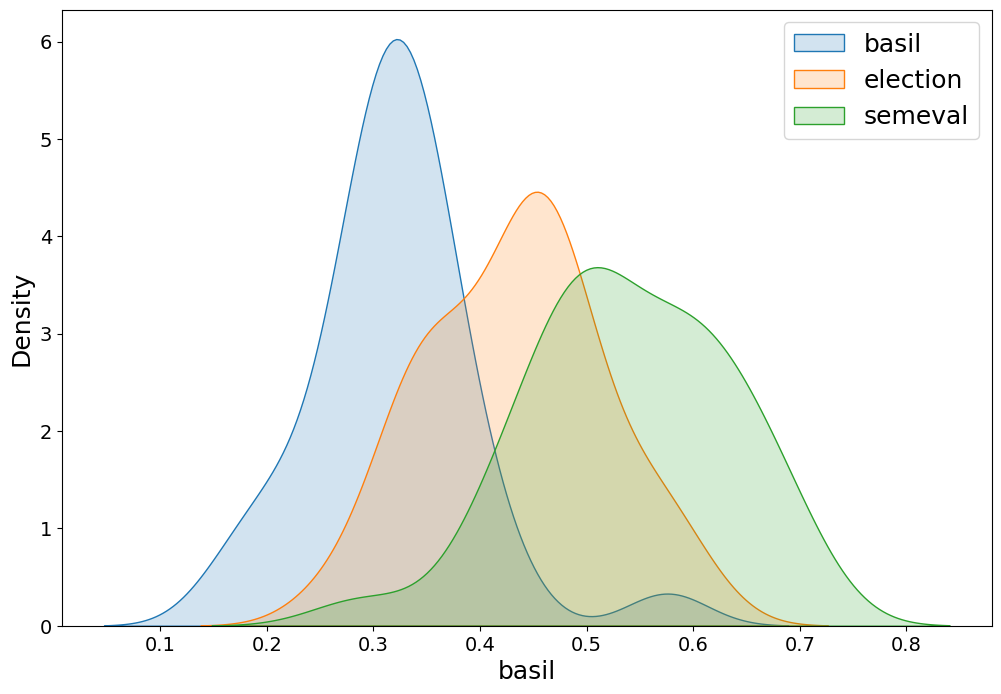

In [42]:
# Specify figure size (width, height)  
plt.figure(figsize=(12, 8))  
  
# Iterate over each column in the dataframe  
for column in clinton_results_df.columns:  
    # Create a density plot for this column's values  
    sns.kdeplot(clinton_results_df[column].dropna(), label=column, fill=True, alpha=0.2)  

# Show legend  
plt.legend()  
  
# Display the plot  
plt.show()  

 Donald Trump

In [43]:
# List of CSV files  
csv_files = glob("bias results/*.csv")  

In [44]:
# Dataframe to hold results  
results = []

for file in csv_files:  
    # Read CSV file  
    df = pd.read_csv(file)
      
    # Get model name from file name  
    model_name = file.split("_")[1].split(".")[0]
    
    # Get dataset name from file split
    dataset_name = file.split("_")[0].split("/")[1]
        
    # Compute F1 scores
    for target in ['Donald Trump']:  
        for col in ["task_preds", "context_preds", "cot_preds", "bias_cot_preds"]:  
            sub_df = df[df['event'] == target]  
            acc = f1_score(sub_df['stance'], sub_df[col], average='macro')  
  
            # Append result to results list  
            result = {"model": model_name, "dataset_name": dataset_name, "prompt": col, "accuracy_score": acc, "num_samples":len(sub_df)}  
            results.append(result)

In [45]:
results_df = pd.DataFrame(results)
trump_results_df = results_df.pivot(index=['model', "prompt"], columns='dataset_name', values='accuracy_score')

In [46]:
trump_results_df

dataset_name                              basil  election  semeval
model                  prompt                                     
Llama-2-13b-chat-hf    bias_cot_preds  0.333177  0.446773      NaN
                       context_preds   0.320000  0.374809      NaN
                       cot_preds       0.369986  0.451728      NaN
                       task_preds      0.351136  0.352454      NaN
Llama-2-7b-chat-hf     bias_cot_preds  0.442412  0.375166      NaN
                       context_preds   0.356194  0.315507      NaN
                       cot_preds       0.386583  0.381085      NaN
                       task_preds      0.300727  0.329404      NaN
Mistral-7B-Instruct-v0 bias_cot_preds  0.345001  0.406046      NaN
                       context_preds   0.395651  0.332561      NaN
                       cot_preds       0.352713  0.398353      NaN
                       task_preds      0.249607  0.273177      NaN
falcon-40b-instruct    bias_cot_preds  0.346926  0.411280      NaN
                       context_preds   0.263925  0.206603      NaN
                       cot_preds       0.311712  0.417064      NaN
                       task_preds      0.305221  0.285251      NaN
falcon-7b-instruct     bias_cot_preds  0.392060  0.288833      NaN
                       context_preds   0.383200  0.241296      NaN
                       cot_preds       0.409026  0.286007      NaN
                       task_preds      0.267996  0.317747      NaN
flan-alpaca-gpt4-xl    bias_cot_preds  0.310932  0.355907      NaN
                       context_preds   0.338054  0.367799      NaN
                       cot_preds       0.325330  0.353742      NaN
                       task_preds      0.286409  0.403040      NaN
flan-ul2               bias_cot_preds  0.249225  0.555039      NaN
                       context_preds   0.262541  0.495069      NaN
                       cot_preds       0.222356  0.546447      NaN
                       task_preds      0.210303  0.403426      NaN
gpt-3                  bias_cot_preds  0.322511  0.370803      NaN
                       context_preds   0.296373  0.527765      NaN
                       cot_preds       0.467467  0.422548      NaN
                       task_preds      0.289322  0.385865      NaN

In [47]:
diff_values = trump_results_df['basil']-trump_results_df['election']
diff_values = diff_values[~np.isnan(diff_values)]
  
# Perform a One-Sample T-test  
t_stat, p_val = stats.ttest_1samp(np.abs(diff_values), 0)  
  
print(f"t-statistic: {t_stat}, p-value: {p_val}")  

t-statistic: 6.330689308351215, p-value: 4.805572360956404e-07


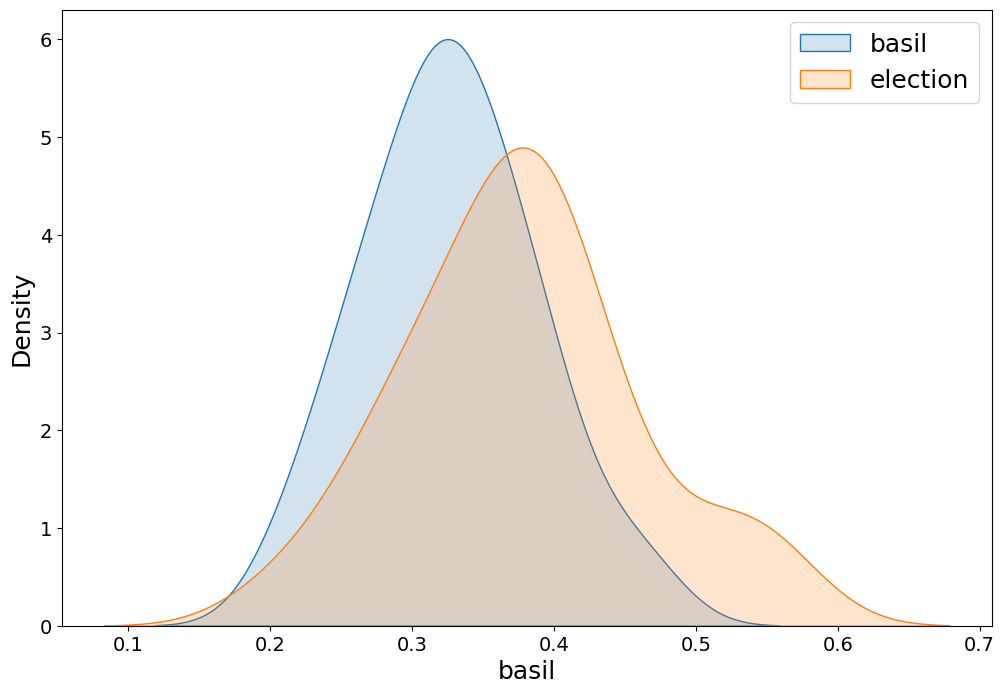

In [48]:
# Specify figure size (width, height)  
plt.figure(figsize=(12, 8))  
  
# Iterate over each column in the dataframe  
for column in ['basil', 'election']:  
    # Create a density plot for this column's values  
    sns.kdeplot(trump_results_df[column].dropna(), label=column, fill=True, alpha=0.2)  

# Show legend  
plt.legend()
  
# Display the plot  
plt.show()  